#3주차 과제 설명
<p>이번 과제의 목표는 세션 시간에 개념으로 배운 Visualization을 직접 실습해보면서 CNN안에서는 무슨 일이 일어나는지, Gradient ascent가 실제로 어떻게 작동하는 것인지 여러분들이 몸소 느끼시는 것입니다.</p>

<p>평소에 하셨던 어떤 모델 구현이나, 학습을 시키는 과정은 아니지만 딥러닝에게 매번 주어지는 근본적인 과제인 "도대체 얘네는 무엇을, 어떻게 하고 있는 것이냐"에 대한 자그마한 체험이시라고 생각하시면 될 것 같습니다 😂</p>

<p> 주어진 과제는 총 3개이며 훌륭한 교보재인 CS231 공식 assignment 3을 대다수 참고하였습니다 🙇🏻‍♂️</p>

# Drive Mount & Download COCO

In [ ]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive')

# 본인의 다운로드받은 폴더경로에 맞게 설정해주시면 됩니다.
FOLDERNAME = "23_summer_cv/3rd/cs231n/assignment3/"
assert FOLDERNAME is not None, "[!] Enter the foldername."

import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

# COCO dataset을 다운받을 수 있게 해줍니다
# if it doesn't already exist.
%cd /content/drive/My\ Drive/$FOLDERNAME/cs231n/datasets/
!bash get_datasets.sh
%cd /content/drive/My\ Drive/$FOLDERNAME

# Network Visualization



*   Image gradients (Gradient ascent)를 활용해 새로운 이미지를 생성해봅니다
*   Pretrained된 모델을 사용하고, loss function을 목적에 맞게 지정하여 이미지 픽셀과 loss간의 gradient를 backpropagation을 통해 계산합니다

*   모델의 가중치는 고정하고, loss를 줄이는 방향으로 새로운 이미지를 합성하기 위해 Gradient descent on the image (Gradient ascent)를 적용합니다

<br>

<h1>Image Generation을 위한 3가지 technique을 학습합니다</h1>


1.   Saliency Maps : 어떤 이미지 픽셀이 classification decision에 영향을 주는가?
2.   Fooling images: pretrained network를 교란시킬 수 있는 image를 만들어보자
3. Class Visualization : 특정 클래스의 classification score를 최대화할 수 있는 이미지를 합성해보자

In [ ]:
# Setup cell.
import torch
import torchvision
import torchvision.transforms as T
import numpy as np
import random
import matplotlib.pyplot as plt
import os
from scipy.ndimage import gaussian_filter1d
from PIL import Image

SQUEEZENET_MEAN = np.array([0.485, 0.456, 0.406], dtype=np.float32)
SQUEEZENET_STD = np.array([0.229, 0.224, 0.225], dtype=np.float32)

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # Set default size of plots.
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

## Help Function



<b>사용할 Pretrained model이 이미 표준화된 이미지에 대해 학습돼서, 과제의 편의를 위해 Model inference에 필요한 전처리 관련 함수들을 미리 모아놓았습니다.</b>



In [ ]:
def preprocess(img, size=224): #Standard-scaling
    transform = T.Compose([
        T.Resize(size),
        T.ToTensor(),
        T.Normalize(mean=SQUEEZENET_MEAN.tolist(),
                    std=SQUEEZENET_STD.tolist()),
        T.Lambda(lambda x: x[None]),
    ])
    return transform(img)

def deprocess(img, should_rescale=True):
    transform = T.Compose([
        T.Lambda(lambda x: x[0]),
        T.Normalize(mean=[0, 0, 0], std=(1.0 / SQUEEZENET_STD).tolist()),
        T.Normalize(mean=(-SQUEEZENET_MEAN).tolist(), std=[1, 1, 1]),
        T.Lambda(rescale) if should_rescale else T.Lambda(lambda x: x),
        T.ToPILImage(),
    ])
    return transform(img)

def rescale(x): #Minmax-scaling
    low, high = x.min(), x.max()
    x_rescaled = (x - low) / (high - low)
    return x_rescaled

def blur_image(X, sigma=1): #Gaussian_filter
    X_np = X.cpu().clone().numpy()
    X_np = gaussian_filter1d(X_np, sigma, axis=2)
    X_np = gaussian_filter1d(X_np, sigma, axis=3)
    X.copy_(torch.Tensor(X_np).type_as(X))
    return X

def jitter(X, ox, oy): #pixel change
    """
    Helper function to randomly jitter an image.

    Inputs
    - X: PyTorch Tensor of shape (N, C, H, W)
    - ox, oy: Integers giving number of pixels to jitter along W and H axes

    Returns: A new PyTorch Tensor of shape (N, C, H, W)
    """
    if ox != 0:
        left = X[:, :, :, :-ox]
        right = X[:, :, :, -ox:]
        X = torch.cat([right, left], dim=3)
    if oy != 0:
        top = X[:, :, :-oy]
        bottom = X[:, :, -oy:]
        X = torch.cat([bottom, top], dim=2)
    return X


Imagenet_valid 데이터를 불러오기 위한 함수입니다 <br>
밑에 다운로드 받을 파일 경로만 수정해주시면 됩니다!

In [ ]:
def load_imagenet_val(num=None):
    """Load a handful of validation images from ImageNet.

    Inputs:
    - num: Number of images to load (max of 25)

    Returns:
    - X: numpy array with shape [num, 224, 224, 3]
    - y: numpy array of integer image labels, shape [num]
    - class_names: dict mapping integer label to class name
    """
    imagenet_fn = os.path.join(######본인경로로 수정해주세요####,"datasets/imagenet_val_25.npz")
    if not os.path.isfile(imagenet_fn):
        print("file %s not found" % imagenet_fn)
        print("Run the following:")
        print("cd cs231n/datasets")
        print("bash get_imagenet_val.sh")
        assert False, "Need to download imagenet_val_25.npz"

    # modify the default parameters of np.load
    # https://stackoverflow.com/questions/55890813/how-to-fix-object-arrays-cannot-be-loaded-when-allow-pickle-false-for-imdb-loa
    np_load_old = np.load
    np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)
    f = np.load(imagenet_fn)
    np.load = np_load_old
    X = f["X"]
    y = f["y"]
    class_names = f["label_map"].item()
    if num is not None:
        X = X[:num]
        y = y[:num]
    return X, y, class_names

# Pretrained Model

## Image Generation 항목에서는 ImageNet에서 pretrained한 model을 사용합니다.


*   특히 여기서는 Squeezenet이라는 모델을 사용하는데 AlexNet과 유사하지만 훨씬 더 가볍고 빠른 모델입니다
*   CPU로도 Image Generation이 가능합니다


[1] Iandola et al, "SqueezeNet: AlexNet-level accuracy with 50x fewer parameters and < 0.5MB model size", arXiv 2016

In [ ]:
# Download and load the pretrained SqueezeNet model.
model = torchvision.models.squeezenet1_1(pretrained=True)

# Gradient 계산 X
for param in model.parameters():
    param.requires_grad = False

## Loading ImageNet Validation Images


*   ImageNet의 validation set image sample들을 살펴봅시다
*   Valid set이므로 Pretrained model이 학습하지 않은 것

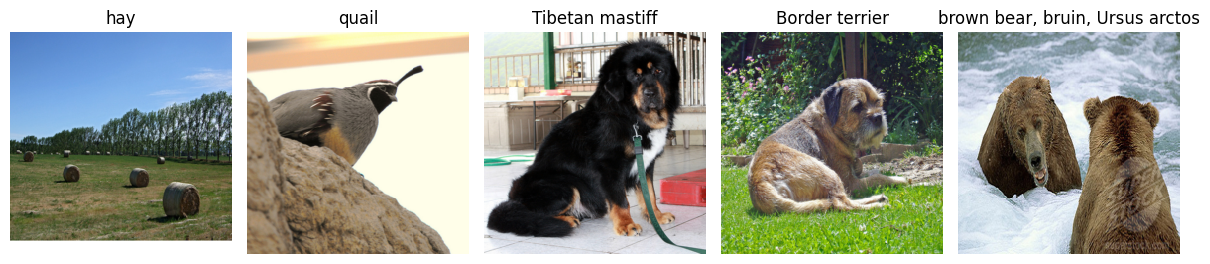

In [ ]:
X, y, class_names = load_imagenet_val(num=5)

plt.figure(figsize=(12, 6))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(X[i])
    plt.title(class_names[y[i]])
    plt.axis('off')
plt.gcf().tight_layout()

# Saliency Maps : 어떤 이미지 픽셀이 classification decision에 영향을 주는가?




1.  정답 클래스에 해당하는 unnormalized score의 gradient를 이미지의 픽셀에 대해 계산합니다.
2.  Image Shape : (3,H,W) -> Gradient Shape : (3,H,W)
3.  각 픽셀에 대하여, gradient는 픽셀값이 바뀔때마다 classification score가 얼만큼 변할지를 의미
4. Gradient의 절댓값 계산 -> 3 channel에 대한 maximum value만 (H,W) saliency map에 보존 (모든 값들은 음수가 아닙니다.)

[2] Karen Simonyan, Andrea Vedaldi, and Andrew Zisserman. "Deep Inside Convolutional Networks: Visualising
Image Classification Models and Saliency Maps", ICLR Workshop 2014.

### Hint: PyTorch `gather` method

*   `s` = PyTorch Tensor of shape `(N, C)` : 2d array
*   `y` = PyTorch Tensor of shape `(N,)` : 1d array containing longs in the range `0 <= y[i] < C`

그러면,

`s.gather(1, y.view(-1, 1)).squeeze()`

*   `s.gather(1, y.view(-1, 1)).squeeze()` : 기존 `(N, C)` 2차원 배열에서 y의 인덱스에 따라 행별로 하나의 원소만을 선택한 `(N,)` 1차원 배열이 된다
*   `s.gather(dim: index하고 싶은 축, index: index에 필요한 원소)`


*   `s.squeeze()` : size가 1인 차원 축소


https://pytorch.org/docs/stable/generated/torch.squeeze<br>
https://pytorch.org/docs/stable/generated/torch.gather

In [ ]:
# Example of using gather to select one entry from each row in PyTorch
def gather_example():
    N, C = 4, 5
    s = torch.randn(N, C)
    y = torch.LongTensor([1, 2, 1, 3])
    print(s)
    print(y)
    print(s.gather(1, y.view(-1, 1)).squeeze())
gather_example()

#과제 1 : Compute Salinecy Maps 함수 짜기

In [ ]:
def compute_saliency_maps(X, y, model):
    """
    Compute a class saliency map using the model for images X and labels y.

    Input:
    - X: Input images; Tensor of shape (N, 3, H, W)
    - y: Labels for X; LongTensor of shape (N,)
    - model: A pretrained CNN

    Returns:
    - saliency: A Tensor of shape (N, H, W) giving the saliency maps for the input
    images.
    """
    # Make sure the model is in "test" mode
    model.eval()

    # Make input tensor require gradient
    X.requires_grad_()

    saliency = None
    ##############################################################################
    # TODO: 굳이 scratch로 구현안하셔도 되고 pytorch 라이브러리 쓰시면 됩니다.

    # 빈칸 작성 3가지
    # 1. Forward pass 구현 : compute the loss over the correct class score
    # 2. Backward pass 구현 : compute gradient of the correct class score
    # 3. saliency 구현
    ##############################################################################
    #1.Forward pass : softmax를 쓰지 않습니다 -> unnormalize score
    #Hint: Loss를 계산하려면 기본적으로 모델의 예측값과 Label값을 이용해야겟죠?
    #추가적으로 Batch내 element loss를 다 합쳐서 loss를 결합해주세요

    loss = #########

    #2.backward pass

    ##########

    #3.우리가 원하는 saliency는 입력 이미지 각각에 관한 class score gradient
    #그래디언트에 절댓값을 씌우고, channel에 대해 max value값을 취해주세요
    saliency =  ########
    ##############################################################################
    #                             END OF YOUR CODE                               #
    ##############################################################################
    return saliency

위에서 구현한 함수를 바탕으로 saliency_map을 visualization해보세요

In [ ]:
def show_saliency_maps(X, y):
    # Convert X and y from numpy arrays to Torch Tensors
    X_tensor = torch.cat([preprocess(Image.fromarray(x)) for x in X], dim=0)
    y_tensor = torch.LongTensor(y)

    # 정답 클래스에 대해서만 saliency_map을 적용
    saliency = compute_saliency_maps(X_tensor, y_tensor, model)

    # Convert the saliency map from Torch Tensor to numpy array and show images
    # and saliency maps together.
    saliency = saliency.numpy()
    N = X.shape[0]
    for i in range(N):
        plt.subplot(2, N, i + 1)
        plt.imshow(X[i])
        plt.axis('off')
        plt.title(class_names[y[i]])
        plt.subplot(2, N, N + i + 1)
        plt.imshow(saliency[i], cmap=plt.cm.hot)
        plt.axis('off')
        plt.gcf().set_size_inches(12, 5)
    plt.show()

show_saliency_maps(X, y)

# Fooling Images : pretrained network를 교란시킬 수 있는 image를 만들어보자

1.   Image와 target class가 주어졌을때, target class의 classification score를 최대화하는 방향으로 gradient ascent를 사용해 image를 update할 수 있습니다
2.   Network가 실제로 이미지를 target class로 분류하면 update를 중지합니다

[3] Szegedy et al, "Intriguing properties of neural networks", ICLR 2014

Implement ```make_fooling_image``` function inside ```cs231n/net_visualization_pytorch.py```

#과제 2 : make_fooling_image 함수 짜기

In [ ]:
def make_fooling_image(X, target_y, model):
    """
    Generate a fooling image that is close to X, but that the model classifies
    as target_y.

    Inputs:
    - X: Input image; Tensor of shape (1, 3, 224, 224)
    - target_y: An integer in the range [0, 1000)
    - model: A pretrained CNN

    Returns:
    - X_fooling: An image that is close to X, but that is classifed as target_y
    by the model.
    """
    # 네트워크를 속일 가짜 이미지를 만듭니다.
    X_fooling = X.clone()
    X_fooling = X_fooling.requires_grad_()

    learning_rate = 1
    ##############################################################################
    # TODO:
    # 1.반복문을 작성하여 target class score에 대한 gradient ascent를 사용해 X_fooling을 update합니다
    # 2.Network가 X_fooling을 target_y로 분류할때까지 반복합니다


    #빈칸 작성 5가지, 아래의 #######부분을 채워주세요
    ##############################################################################
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

    while True:
        #1. 모델의 output을 얻으세요
        pred_y = #######

        #2. 모델의 output이 target class이라면?
        ########

        #3. 여기서의 Loss는 무엇일까요? 우리가 무엇을 하기 위해 fooling image를 만들었나요?
        loss = #####

        #4. Backpropagation
        ##########

        #5.Gradient ascent를 통해 image update를 진행합니다.
        #Image update를 하고나서는 반드시 이것을 해줘야합니다. 그래야 반복해서 그래디언트를 계산하겟죠?
        #Hint: dX = learning_rate * g / ||g||_2. (L2 norm을 적용한 normliazed graient step을 사용합니다)
        X_fooling.data += ########
        ##########

    ##############################################################################
    #                             END OF YOUR CODE                               #
    ##############################################################################
    return X_fooling

In [ ]:
idx = 0
target_y = 6

X_tensor = torch.cat([preprocess(Image.fromarray(x)) for x in X], dim=0)
X_fooling = make_fooling_image(X_tensor[idx:idx+1], target_y, model)

scores = model(X_fooling)
assert target_y == scores.data.max(1)[1][0].item(), 'The model is not fooled!'

Fooling image를 만들어보고 original image와 비교해보세요!

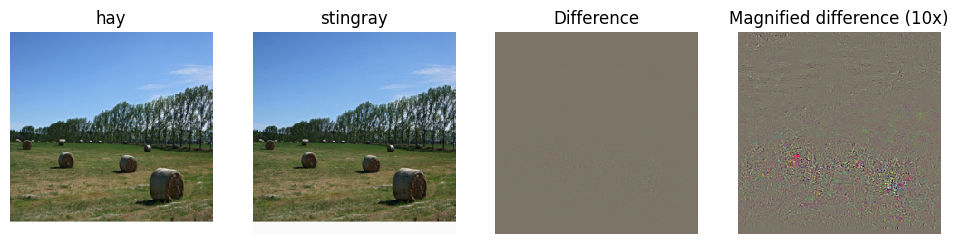

In [ ]:
X_fooling_np = deprocess(X_fooling.clone())
X_fooling_np = np.asarray(X_fooling_np).astype(np.uint8)

plt.subplot(1, 4, 1)
plt.imshow(X[idx])
plt.title(class_names[y[idx]])
plt.axis('off')

plt.subplot(1, 4, 2)
plt.imshow(X_fooling_np)
plt.title(class_names[target_y])
plt.axis('off')

plt.subplot(1, 4, 3)
X_pre = preprocess(Image.fromarray(X[idx]))
diff = np.asarray(deprocess(X_fooling - X_pre, should_rescale=False))
plt.imshow(diff)
plt.title('Difference')
plt.axis('off')

plt.subplot(1, 4, 4)
diff = np.asarray(deprocess(10 * (X_fooling - X_pre), should_rescale=False))
plt.imshow(diff)
plt.title('Magnified difference (10x)')
plt.axis('off')

plt.gcf().set_size_inches(12, 5)
plt.show()

# Class Visualization : 특정 클래스의 classification score를 최대화할 수 있는 이미지를 합성해보자


1. Class Visualization은 랜덤 노이즈 이미지를 시작으로 target class에 대해 gradient ascent를 수행하여, network가 target class로 인식하는 이미지를 생성하는 기법입니다.
2. Several Regularization technique과 함께 쓰여 generated image를 자연스럽게 보이도록 합니다.
3. $s_y(I)$ : CNN이 image $I$를 class $y$라고 classification하는 score (before softmax)
4. $R$ : L2 Regularizer
$$
I^* = \arg\max_I (s_y(I) - R(I))
$$

$$
R(I) = \lambda \|I\|_2^2
$$

5. 위의 Optimization problem을 gradient ascent로 해결하는 것


[2] Karen Simonyan, Andrea Vedaldi, and Andrew Zisserman. "Deep Inside Convolutional Networks: Visualising
Image Classification Models and Saliency Maps", ICLR Workshop 2014.

[3] Yosinski et al, "Understanding Neural Networks Through Deep Visualization", ICML 2015 Deep Learning Workshop

#과제 3 : class_visualization_update_step 함수 짜기

In [ ]:
def class_visualization_update_step(img, model, target_y, l2_reg, learning_rate):
    ########################################################################
    #TODO:
    #1.target_y class score에 대한 image 픽셀의 gradient 계산
    #2.Gradient ascent 수행 with regularization


    #과제 2와 과정이 거의 유사하므로 위의 2가지를 수행할 수 있는 코드를 자유롭게 작성해주세요
    #Regularization이 들어가므로 부호에 주의하세요!
    ########################################################################
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

    ######################
    ######################

    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    ########################################################################
    #                             END OF YOUR CODE                         #
    ########################################################################

In [ ]:
def create_class_visualization(target_y, model, dtype, **kwargs):
    """
    Generate an image to maximize the score of target_y under a pretrained model.

    Inputs:
    - target_y: Integer in the range [0, 1000) giving the index of the class
    - model: A pretrained CNN that will be used to generate the image
    - dtype: Torch datatype to use for computations

    Keyword arguments:
    - l2_reg: Strength of L2 regularization on the image
    - learning_rate: How big of a step to take
    - num_iterations: How many iterations to use
    - blur_every: How often to blur the image as an implicit regularizer
    - max_jitter: How much to gjitter the image as an implicit regularizer
    - show_every: How often to show the intermediate result
    """
    model.type(dtype)
    l2_reg = kwargs.pop('l2_reg', 1e-3)
    learning_rate = kwargs.pop('learning_rate', 25)
    num_iterations = kwargs.pop('num_iterations', 100)
    blur_every = kwargs.pop('blur_every', 10)
    max_jitter = kwargs.pop('max_jitter', 16)
    show_every = kwargs.pop('show_every', 25)

    # Randomly initialize the image as a PyTorch Tensor, and make it requires gradient.
    img = torch.randn(1, 3, 224, 224).mul_(1.0).type(dtype).requires_grad_()

    for t in range(num_iterations):
        # Randomly jitter the image a bit; this gives slightly nicer results
        ox, oy = random.randint(0, max_jitter), random.randint(0, max_jitter)
        img.data.copy_(jitter(img.data, ox, oy))
        class_visualization_update_step(img, model, target_y, l2_reg, learning_rate)
        # Undo the random jitter
        img.data.copy_(jitter(img.data, -ox, -oy))

        # As regularizer, clamp and periodically blur the image
        for c in range(3):
            lo = float(-SQUEEZENET_MEAN[c] / SQUEEZENET_STD[c])
            hi = float((1.0 - SQUEEZENET_MEAN[c]) / SQUEEZENET_STD[c])
            img.data[:, c].clamp_(min=lo, max=hi)
        if t % blur_every == 0:
            blur_image(img.data, sigma=0.5)

        # Periodically show the image
        if t == 0 or (t + 1) % show_every == 0 or t == num_iterations - 1:
            plt.imshow(deprocess(img.data.clone().cpu()))
            class_name = class_names[target_y]
            plt.title('%s\nIteration %d / %d' % (class_name, t + 1, num_iterations))
            plt.gcf().set_size_inches(4, 4)
            plt.axis('off')
            plt.show()

    return deprocess(img.data.cpu())

실제 원하는 target class의 이미지가 만들어지는 과정을 살펴보세요

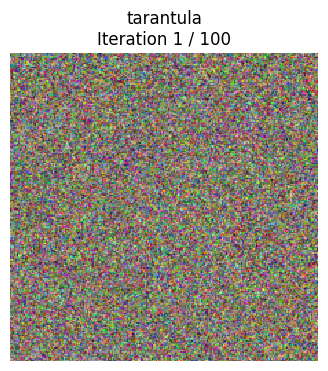

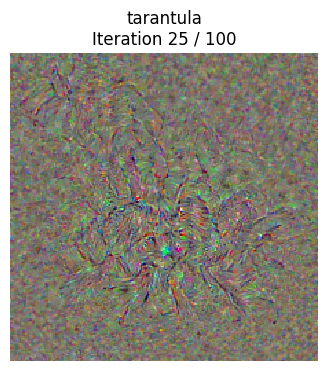

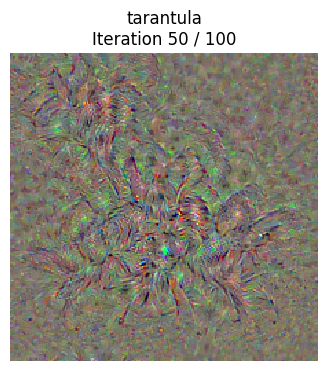

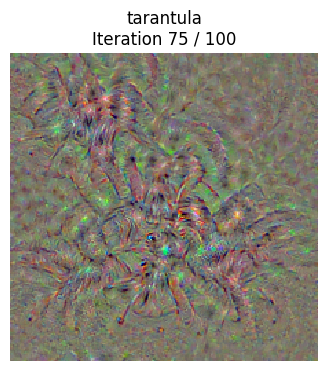

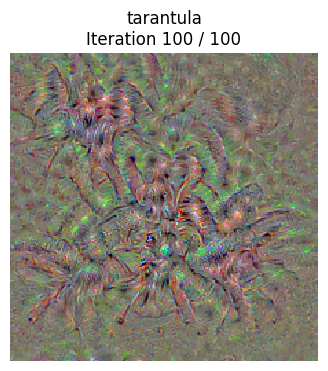

In [ ]:
dtype = torch.FloatTensor
model.type(dtype)

target_y = 76 # Tarantula
# target_y = 78 # Tick
# target_y = 187 # Yorkshire Terrier
# target_y = 683 # Oboe
# target_y = 366 # Gorilla
# target_y = 604 # Hourglass
out = create_class_visualization(target_y, model, dtype)

pier


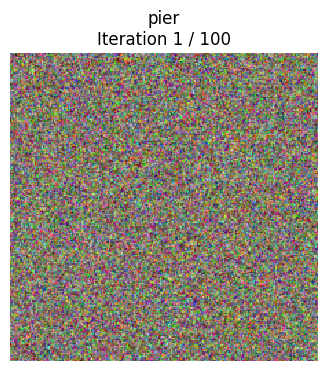

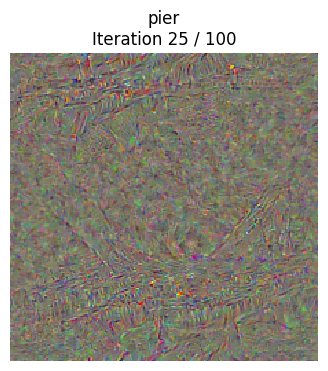

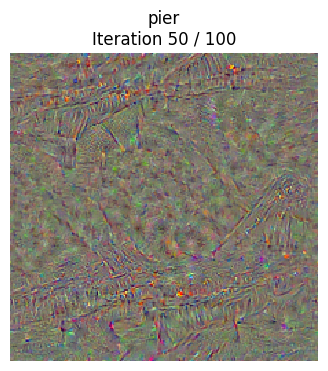

KeyboardInterrupt: ignored

In [ ]:
# target_y = 78 # Tick
# target_y = 187 # Yorkshire Terrier
# target_y = 683 # Oboe
# target_y = 366 # Gorilla
# target_y = 604 # Hourglass
target_y = np.random.randint(1000)
print(class_names[target_y])
X = create_class_visualization(target_y, model, dtype)